In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
from pathlib import Path
import kagglehub
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [46]:
def get_dataset(dataset_name):
    """Check if a dataset with the given name exists locally before downloading it."""
    base_cache_path = os.path.expanduser("~/.cache/kagglehub/datasets")

    # Search for any dataset folder containing the dataset name
    for root, dirs, _ in os.walk(base_cache_path):
        for dir_name in dirs:
            if dataset_name.split("/")[-1] in dir_name:  # Check if dataset name is in folder
                dataset_path = os.path.join(root, dir_name)
                print(f"Dataset already exists at: {dataset_path}")
                return dataset_path

    # If not found, download it
    print("Dataset not found. Downloading...")
    path = kagglehub.dataset_download(dataset_name)
    print("Dataset downloaded to:", path)
    return path

# Example usage
dataset_path = get_dataset("paultimothymooney/chest-xray-pneumonia")


Dataset already exists at: C:\Users\Rik/.cache/kagglehub/datasets\paultimothymooney\chest-xray-pneumonia


In [47]:

# Set base folder
base_path = Path.home() / ".cache" / "kagglehub" / "datasets" / "paultimothymooney" / "chest-xray-pneumonia"
chest_xray_folders = list(base_path.glob("**/chest_xray"))

if not chest_xray_folders:
    raise FileNotFoundError(f"No 'chest_xray' folder found in {base_path}")

base_folder = chest_xray_folders[0]
print(f"Using dataset folder: {base_folder}")

train_folder = base_folder / "train"
val_folder = base_folder / "val"
test_folder = base_folder / "test"

# Check if base_folder exists and display its contents
if base_folder.exists():
    print("Contents of base_folder:", os.listdir(base_folder))
else:
    raise FileNotFoundError(f"Base folder does not exist: {base_folder}")

# Check if directories exist
if not train_folder.exists():
    raise FileNotFoundError(f"Train folder not found: {train_folder}")
if not val_folder.exists():
    raise FileNotFoundError(f"Validation folder not found: {val_folder}")
if not test_folder.exists():
    raise FileNotFoundError(f"Test folder not found: {test_folder}")

print("All dataset folders exist.")



Using dataset folder: C:\Users\Rik\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray
Contents of base_folder: ['chest_xray', 'test', 'train', 'val', '__MACOSX']
All dataset folders exist.


In [48]:
img_height, img_width = 64, 64  
batch_size = 32

In [49]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Only rescaling for the validation and test sets
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories using flow_from_directory
training_set = train_datagen.flow_from_directory(
    directory=str(train_folder),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42 # Add a seed for reproducibility
)

validation_generator = test_datagen.flow_from_directory(
    directory=str(val_folder),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42 # Add a seed for reproducibility
)

test_set = test_datagen.flow_from_directory(
    directory=str(test_folder),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False, # Important for confusion matrix
    seed=42 # Add a seed for reproducibility
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [50]:
cnn = Sequential()

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


c:\Users\Rik\Desktop\Pneumonia-challenge\.pneum\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [52]:
# Train the model
cnn_model = cnn.fit(
    training_set,
    steps_per_epoch=training_set.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

c:\Users\Rik\Desktop\Pneumonia-challenge\.pneum\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 360ms/step - accuracy: 0.7909 - loss: 0.4790 - val_accuracy: 0.6875 - val_loss: 0.5736
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 351ms/step - accuracy: 0.9090 - loss: 0.2239 - val_accuracy: 0.8750 - val_loss: 0.3117
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 338ms/step - accuracy: 0.9167 - loss: 0.1970 - val_accuracy: 0.8750 - val_loss: 0.2814
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 366ms/step - accuracy: 0.9106 - loss: 0.2120 - val_accuracy: 0.5625 - val_loss: 1.4942
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 425ms/step - accuracy: 0.9195 - loss: 0.1991 - val_accuracy: 0.6250 - val_loss: 0.8060
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.9303 - loss: 0.1785 - val_accuracy: 0.7500 - val_loss: 0.4581
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 345ms/step - accuracy: 0.9350 - loss: 0.1668 - val_accuracy: 0.7500 - val_loss: 0.3433
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 350ms/step - accuracy: 0.9408 - loss: 0

In [63]:
test_loss, test_accuracy = cnn.evaluate(test_set, steps=test_set.samples // batch_size)
print(f"Test Accuracy: {test_accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.7865 - loss: 0.4902
Test Accuracy: 0.8536


In [54]:
# Get predictions from the test set
predictions = cnn.predict(test_set)
predicted_classes = (predictions > 0.5).astype("int32")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step


In [55]:
# Get true labels
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [56]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[165  69]
 [ 21 369]]


In [57]:
# Classification Report
cr = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:")
print(cr)


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.89      0.71      0.79       234
   PNEUMONIA       0.84      0.95      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624



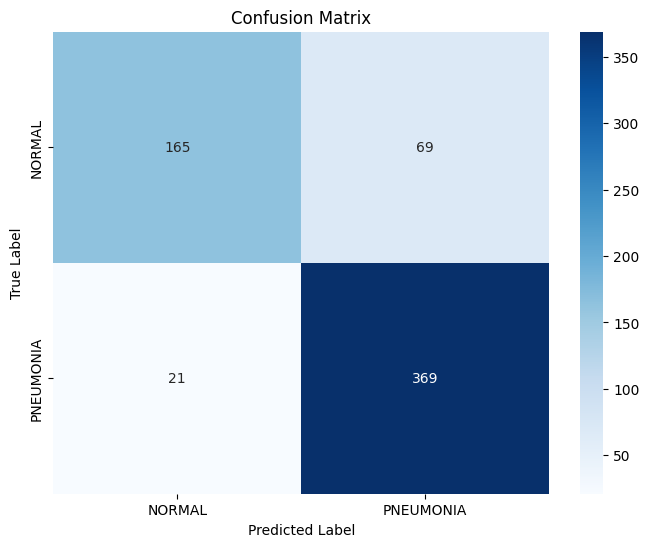

In [58]:
# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

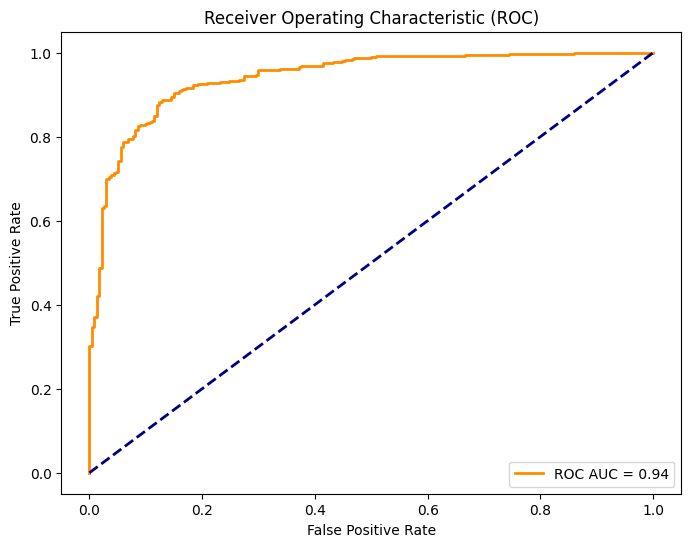

In [59]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

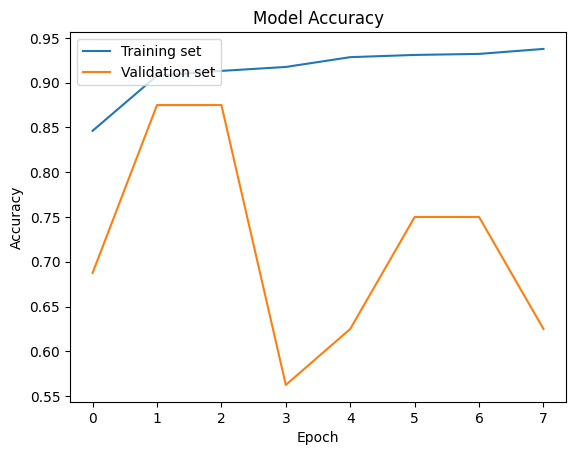

In [66]:
# Accuracy 
plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

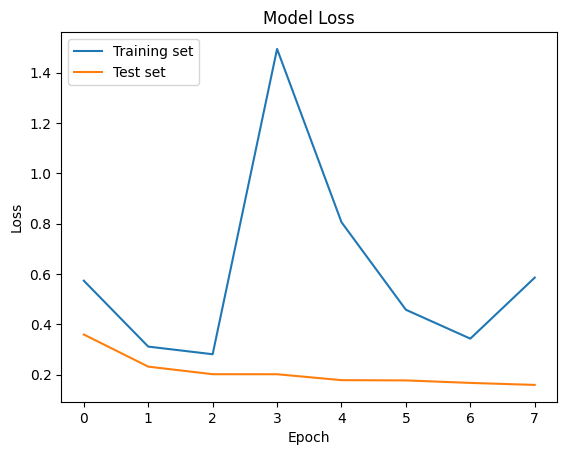

In [67]:
plt.plot(cnn_model.history['val_loss'])
plt.plot(cnn_model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()